# Support Vector Machines on the ionosphere dataset
#### Mario Martin (updated by Manuel Gijón on May 24)

We used this dataset in the Meta-methods notebook, so open it in another window to compare results with other methods.

In [1]:
import numpy as np
import pandas as pd

import sklearn
import sklearn.datasets as ds
import sklearn.model_selection as cv
import sklearn.neighbors as nb
from sklearn.model_selection import (
    cross_val_score, 
    GridSearchCV, 
    validation_curve,
)
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler,
)
from sklearn.svm import (
    LinearSVC, 
    SVC,
)
from sklearn.ensemble import (
    ExtraTreesClassifier, 
    AdaBoostClassifier, 
    BaggingClassifier,
)
from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt

%matplotlib inline              

In [2]:
csv = "preprocessed_encoded.csv"
df = pd.read_csv(csv)


old_df = pd.read_csv('preprocessed.csv')

y = old_df['match']

X = df


# X = df.values[:,0:34].astype("float32")

Let's separate the data into training (for adjusting parameters), and validation. 

In [3]:
(X_train, X_test,  y_train, y_test) = cv.train_test_split(X, y, test_size = .3, stratify = y, random_state = 1)

# Normalization of the data starting from information of just the training set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Apply the scaler to the test set
X_test = scaler.transform(X_test)

# Oversample the data to have a more balanced dataset
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

Notice the stratification according to labels *y* that we demand in the spliting of data. The ionosphere dataset is small and with strarification we ensure we obtain the same proportion of examples of each class in training and test sets.

#### **Remember**: Data should be numerical and normalized or standarized before using an SVM. 

In [4]:
df.describe()

,wave,age,age_o,d_age,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,...,field_physics [astrophysics],field_political science,field_psychology,field_psychology and english,field_social work,field_sociology,field_speech pathology,field_teaching of English,field_theory,field_working
count,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,...,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000
mean,11.350919,26.354858,26.360468,4.185605,3.777393,3.645500,22.468839,17.407205,20.267883,17.466034,...,0.001910,0.004297,0.004536,0.001194,0.003103,0.006207,0.001671,0.001790,0.000597,0.001790
std,5.995903,3.546684,3.541689,4.596171,2.833273,2.792688,12.505468,7.007194,6.746824,6.050104,...,0.043662,0.065414,0.067199,0.034530,0.055625,0.078543,0.040847,0.042278,0.024424,0.042278
min,1.000000,18.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,24.000000,24.000000,1.000000,1.000000,1.000000,15.000000,15.000000,17.650000,15.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11.000000,26.000000,26.000000,3.000000,3.000000,3.000000,20.000000,18.370000,20.000000,18.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15.000000,28.000000,28.000000,5.000000,6.000000,6.000000,25.000000,20.000000,23.260000,20.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,21.000000,55.000000,55.000000,37.000000,10.000000,10.000000,100.000000,60.000000,50.000000,50.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


However, let's see how to do that properly:

In [5]:
#scaler = StandardScaler().fit(X_train)
scaler = MinMaxScaler(feature_range = (-1, 1)).fit(X_train)

# Apply the normalization trained in training data in both training and test sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Linear SVM

Let's try an SVM with default parameters. Linear means that we are not using any kernel to move the data to a higher dimensional space.

In [6]:
#knc = LinearSVC() 
knc = SVC(kernel = "linear")
knc.fit(X_train, y_train)
prediction = knc.predict(X_test)

print(f"Confusion matrix on test set: \n{sklearn.metrics.confusion_matrix(y_test, prediction)}")
print(f"Accuracy on test set: {sklearn.metrics.accuracy_score(y_test, prediction)}")

Confusion matrix on test set: 
[[1624  476]
 [  98  316]]
Accuracy on test set: 0.771678599840891


Not bad results. However, the linear SVM has parameter C that has to be adjusted. We will use **GridSearch** method to find the optimal value of C like we did in a previous notebook with the k value of the KNN algorithm.  

/home/pau.cusco/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/pau.cusco/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/pau.cusco/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/pau.cusco/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/pau.cusco/.local/lib/p

Millor resultat cerca logarítmica: {'C': 0.1} 0.8096143503366617


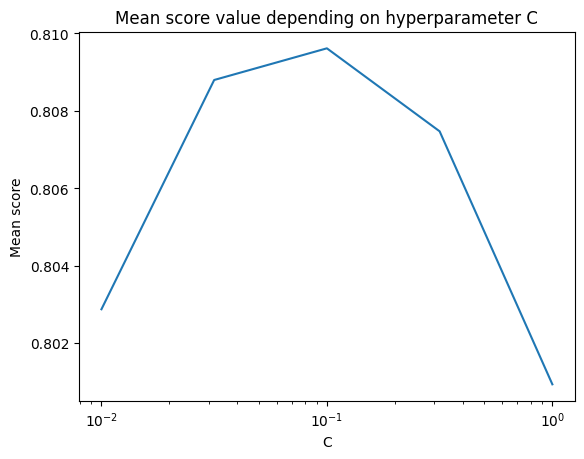

Acc. 10-fold cross on train data = 0.810224927560401


In [8]:
# List of C values to test. We usualy test diverse orders of magnitude
#Cs = np.logspace(-3, 11, num=9, base=10.0)
Cs = np.logspace(-2, -0, num=5, base = 10.0)

param_grid = {"C": Cs}
#grid_search = GridSearchCV(LinearSVC(), param_grid, cv=10)
grid_search = GridSearchCV(
    # SVC(kernel = "linear"), 
    LinearSVC(),
    param_grid, 
    cv = 10,
    n_jobs = -1
)
grid_search.fit(X_train, y_train)
print("Millor resultat cerca logarítmica:", grid_search.best_params_, grid_search.best_score_)


# Let's plot the 10-fold cross.validation accuracy deppending on C
scores = grid_search.cv_results_["mean_test_score"]
plt.title("Mean score value depending on hyperparameter C")
plt.xlabel("C")
plt.ylabel("Mean score")
plt.semilogx(Cs,scores)
plt.show()

parval=grid_search.best_params_
cvacc = cross_val_score(
    SVC(C = parval["C"], kernel = "linear"), 
    X = X_train,
    y = y_train, 
    cv = 10, 
    scoring = "accuracy"
)
print(f"Acc. 10-fold cross on train data = {cvacc.mean()}")


In [9]:

# Let's apply the best C parameter found to the test set
#knc = LinearSVC(C=parval['C']) 
knc = SVC(
    C = parval["C"],
    kernel = "linear"
)
knc.fit(X_train, y_train)
prediction = knc.predict(X_test)

print(f"\nConfusion matrix on test set:\n {sklearn.metrics.confusion_matrix(y_test, prediction)}")
print(f"\nAccuracy on test set: {sklearn.metrics.accuracy_score(y_test, prediction)}")
print(f"\nBest value of parameter C found: {parval}")
print(f"\nNumber of supports: {np.sum(knc.n_support_)} ({np.sum(np.abs(knc.dual_coef_)==parval['C'])} of them have slacks)")
print(f"Prop. of supports: {np.sum(knc.n_support_)/X_train.shape[0]}")


Confusion matrix on test set:
 [[1611  489]
 [  92  322]]

Accuracy on test set: 0.7688941925218775

Best value of parameter C found: {'C': 0.1}

Number of supports: 4980 (4506 of them have slacks)
Prop. of supports: 0.5083707635769702


On this dataset, the best C for a linear SVM is 1 (that casually is also the default value for parameter C) so we don't obtain any improvement tuning the C parameter. However, in other datasets we could obtain a dramatic increase of accuracy. 

Let's see (just for fun) how the C parameter affects performance on training and test sets. 

In [10]:
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    """Plot validation curve.
    Parameters: 
    parameter_values (List[float])  : x-axis values. Paramether that change during execution.
    train_scores     (List[float])  : results on train set.
    test_scores      (List[float])  : results on test set.
    
    Returns:
    None
    """
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    validation_scores_mean = np.mean(validation_scores, axis = 1)
    validation_scores_std = np.std(validation_scores, axis = 1)

    plt.fill_between(
        x = parameter_values, 
        y1 = train_scores_mean - train_scores_std,
        y2 = train_scores_mean + train_scores_std, 
        alpha = 0.1,
        color = "r"
    )
    plt.fill_between(
        x = parameter_values,
        y1 = validation_scores_mean - validation_scores_std,
        y2 = validation_scores_mean + validation_scores_std, 
        alpha = 0.1, 
        color = "g"
    )
    plt.plot(
        parameter_values, 
        train_scores_mean, 
        "o-", 
        color = "r",
        label = "Training score"
    )
    plt.plot(
        parameter_values, 
        validation_scores_mean, 
        "o-", 
        color = "g",
        label = "Cross-validation score"
    )
    plt.ylim(
        validation_scores_mean.min() - .1, 
        train_scores_mean.max() + .1
    )
    plt.legend(loc = 4)

/home/pau.cusco/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/pau.cusco/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/pau.cusco/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/pau.cusco/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/pau.cusco/.local/lib/p

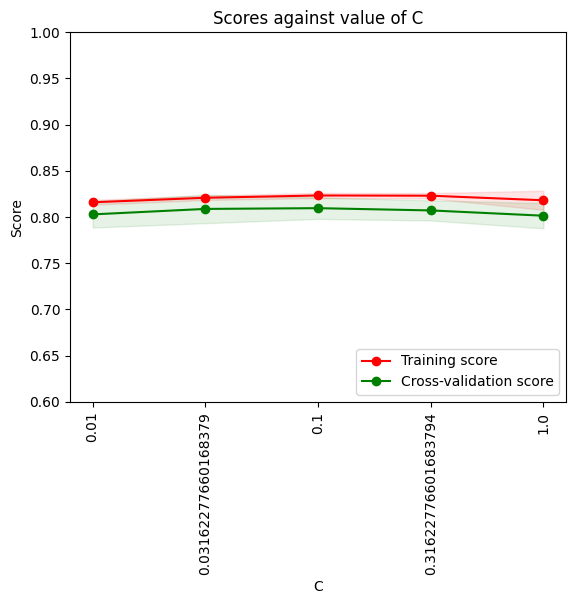

In [11]:
training_scores, test_scores = validation_curve(
    LinearSVC(), 
    X_train, 
    y_train, 
    param_name = "C", 
    param_range = Cs,
    cv = 10
)
# Create the plot
plot_validation_curve(
    range(len(Cs)), 
    training_scores, 
    test_scores
)
plt.xticks(
    range(len(Cs)), 
    Cs,
    rotation = "vertical"
);
plt.ylim([0.6, 1])
plt.title("Scores against value of C")
plt.ylabel("Score")
plt.xlabel("C")
plt.show()

Notice that from value of C=1, increasing C results in better accuracy on the training set but worse performance on the test set. This is because being too demanding on the separation of data in the training dataset, we are overfitting to it and we decrease performance in the test set. A nice picture of typical overfitting.

## Polynomial kernels

We have seen that performance with a linear SVM is Ok but not competitive with Metamethods. However, it could happen that using kernels we could even improve accuracy. We'll try first ploynomial kernel with degree 2 with default parameters.

In [7]:
knc = SVC(
    kernel = "poly",
    degree = 2,
    C = 10
) 
knc.fit(X_train, y_train)
prediction = knc.predict(X_test)

print(f"Confusion matrix on test set:\n {sklearn.metrics.confusion_matrix(y_test, prediction)}")
print(f"\nAccuracy on test set: {sklearn.metrics.accuracy_score(y_test, prediction)}")

Confusion matrix on test set:
 [[1695  405]
 [ 119  295]]

Accuracy on test set: 0.7915672235481305


Better performance than the obtained with a linear SVM... It could even be increased because we didn't tune the C parameter for the polynomial kernel. Let's do that now.

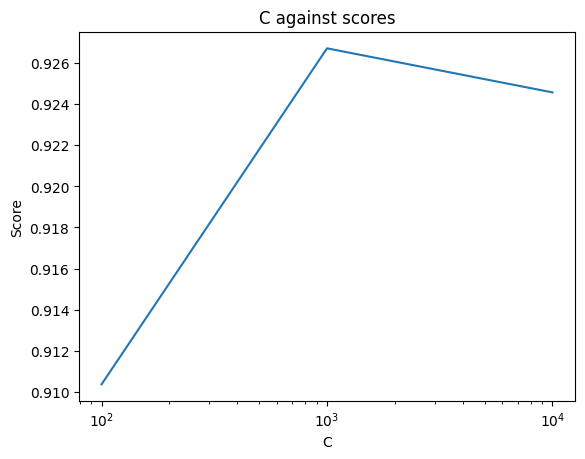

In [8]:
Cs = np.logspace(2, 4, num = 3, base = 10.0)

param_grid = {"C": Cs}
grid_search = GridSearchCV(
    SVC(kernel = "poly",degree = 2) , 
    param_grid, 
    # cv = 10,
    cv = 5,
    n_jobs = -1
)
grid_search.fit(X_train,y_train)

scores = grid_search.cv_results_['mean_test_score']

plt.semilogx(Cs, scores)
plt.title("C against scores")
plt.xlabel("C")
plt.ylabel("Score")
plt.show()

parval = grid_search.best_params_

In [9]:

cvacc = cross_val_score(SVC(kernel='poly',degree =2,C=parval['C']) , X=X_train,  y=y_train, cv=10, scoring='accuracy', n_jobs = -1)
print('Acc. 10-fold cross on train data= ', cvacc.mean())


Acc. 10-fold cross on train data=  0.9304808113235079


In [11]:

knc = SVC(kernel='poly',degree =2, C=parval['C']) 
knc.fit(X_train, y_train)
prediction =knc.predict(X_test)
print(f"\nConfusion matrix on test set:\n {sklearn.metrics.confusion_matrix(y_test, prediction)}")
print(f"\nAccuracy on test set: {sklearn.metrics.accuracy_score(y_test, prediction)}")
print(f"\nBest combination of parameters found: {parval}")
print(f"\nNumber of supports: {np.sum(knc.n_support_)} ({np.sum(np.abs(knc.dual_coef_)==parval['C'])} of them have slacks)")
print(f"Prop. of supports: {np.sum(knc.n_support_)/X_train.shape[0]}")


Confusion matrix on test set:
 [[1848  252]
 [ 219  195]]

Accuracy on test set: 0.8126491646778043

Best combination of parameters found: {'C': 1000.0}

Number of supports: 4110 (117 of them have slacks)
Prop. of supports: 0.4195590036749694


Best result so far. Competitive with meta-methods. Now the best C value found is 100 and accuracy is a lot higher than with default parameters. It's always important when working with SVMs to find best parameters. 

For this C value we have a nice accuracy on the test set. Let's try what happens now with a polynomial kernel of degree 3.

In [12]:
# Utilitzar el millor valor de C trobat per entrenar el model final
best_C = 1000.0
final_model = SVC(kernel="poly", degree=2, C=best_C)
final_model.fit(X_train, y_train)

test_score = final_model.score(X_test, y_test)
print("Test score with best C:", test_score)

Test score with best C: 0.8126491646778043


 Confusion matrix shows only 1 more error than the confusion matrix obtained with the quadratic kernel. Given the low number of cases we have in the test set, we cannot conclude that polynomial kernel with degree 2 is better than with degree 3. But remember that when there are several classifiers with a similar performance, we should always choose the simpler one! So we will choose the quadratic polynomial kernel as best polynomial kernel, not because of performance only but because is the better combination of performance and simplicity.

## RBF Kernel

There's another possibility for the kernel: The RBF kernel. This is the default kernel in the implementation of SVMs in sklearn, so we don't need to explicitely say the kernel used. Let's try it with default parameters.

In [13]:
knc = SVC() 
knc.fit(X_train, y_train)
prediction = knc.predict(X_test)
print(f"Confusion matrix on test set:\n{sklearn.metrics.confusion_matrix(y_test, prediction)}")
print(f"\nAccuracy on test set: {sklearn.metrics.accuracy_score(y_test, prediction)}")

Confusion matrix on test set:
[[1618  482]
 [  92  322]]

Accuracy on test set: 0.771678599840891


Promising performance for default parameters. But we have to search for the best parameters. In this case we have two parameters to adjust: the C parameter and the gamma parameter. We will find the best combination using the *GridSearch* method.

In [19]:
# Values we will test for each parameter. When observin results, consider the limits of the 
# values tested and increase them if necessary 
gammas = [0.0001, 0.001, 0.01, 0,1]
Cs = np.logspace(0, 3, num = 4, base = 10.0)

param_grid = {
    "C": Cs, 
    "gamma" : gammas
}
grid_search = GridSearchCV(
    SVC(), 
    param_grid, 
    # cv = 10
    cv = 5,
    n_jobs = -1
)
grid_search.fit(X_train,y_train)
parval = grid_search.best_params_

# We'll show in a grid, the accuracy for each combination of parameters tester
scores = grid_search.cv_results_["mean_test_score"]
scores = np.array(scores).reshape(  # In order to have it "grid-shaped"
    len(param_grid['C']), 
    len(param_grid['gamma'])
)


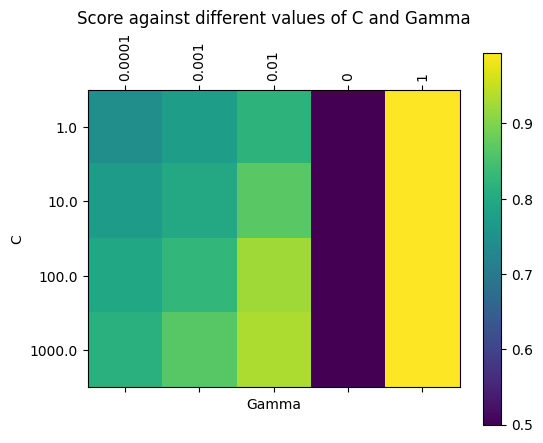


Best combination of parameters found: {'C': 1.0, 'gamma': 1}

Acc. 10-fold cross on train data = 0.9942848804486044


In [20]:

plt.matshow(scores)
plt.title("Score against different values of C and Gamma")
plt.xlabel("Gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(
    np.arange(len(param_grid["gamma"])), 
    param_grid["gamma"],
    rotation = "vertical"
)
plt.yticks(
    np.arange(len(param_grid["C"])), 
    param_grid["C"]
)
plt.show()
parval = grid_search.best_params_
print(f"\nBest combination of parameters found: {parval}")


cvacc = cross_val_score(
    SVC(
        C = parval["C"], 
        gamma = parval["gamma"]
    ), 
    X = X_train,  
    y = y_train, 
    cv = 10, 
    scoring = "accuracy",
    n_jobs = -1
)
print(f'\nAcc. 10-fold cross on train data = {cvacc.mean()}')

This picture show for each combination of parameters the accuracy obtained in a 10-fold cross-validation. Notice the relation between C and gamma. 

Let's see the performance of the best parameters found on the test set.

In [ ]:
# Let's apply the best combination of parameters found to the test set
knc = SVC(
    C = parval["C"], 
    gamma = parval["gamma"]
) 
knc.fit(X_train, y_train)
prediction = knc.predict(X_test)

print(f"Confusion matrix on test set:\n{sklearn.metrics.confusion_matrix(y_test, prediction)}")
print(f"\nAccuracy on test set: {sklearn.metrics.accuracy_score(y_test, prediction)}")
print(f"\nNumber of supports: {np.sum(knc.n_support_)} ({np.sum(np.abs(knc.dual_coef_)==parval['C'])} of them have slacks)")
print(f"Prop. of supports: {np.sum(knc.n_support_)/X_train.shape[0]}")

Confusion matrix on test set:
[[1878  222]
 [ 226  188]]

Accuracy on test set: 0.8217979315831344

Number of supports: 3994 (44 of them have slacks)
Prop. of supports: 0.4077174356880359


Wow. Best performance obtained so far using any method, even better than results obtained with meta-methods. 

**Observations about number and percentage of supports vectors:** 
It is know that percentage of supports of an SVM is a lower bound for the leave-one-out error. In general, an SVM with a lot of supports will be an overfitted SVM. A percentage of supports higher than 50% should be considered suspicious. If this happens, try to use other kernels. As a rule of thumb, a good SVM has a percentatge of supports vectors about 20-40% of the data (but that depends on a lot of things).

In our case all SVM have a low number of supports. And notice that the machine with a higher performance is the one with a lower number of supports (24.9%). That's not a coincidence but something common in SVMs.